## Анализ обнаружения человека в помещении

### Введение

#### Цель проекта

Проект направлен на построение моделей по обнаружению присутствия человека в помещении по состоянию среды внутри этого помещения.

#### Имеющиеся признаки

Признак | Описание
:--------|:---------
date| Дата и время измерения с интервалом в минуту
Temperature| Температура в градусах Цельсия
Humidity | Относительная влажность в %
Light | Освещенность в Люксах
CO2 | Концентрация углекислого газа в миллионных долях
HumidityRatio | Величина, зависимая от влажности и температуры


#### Предсказываемый признак

Признак | Описание
:--------|:---------
Occupancy | 1 - Есть человек в помещении, 0 - человека нет

### Ознакомление с данными и их подготовка

In [143]:
# Импортируем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.mode.chained_assignment = None 

In [144]:
# Считываем тренировочные данные
train = pd.read_csv('train.csv', delimiter="," , index_col='id')
train.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
id,,,,,,,
0,02.02.2015,23.7000,26.272,585.200000,749.200000,0.004764,1
1,02.02.2015,23.7180,26.290,578.400000,760.400000,0.004773,1
2,02.02.2015,23.7300,26.230,572.666667,769.666667,0.004765,1
3,02.02.2015,23.7225,26.125,493.750000,774.750000,0.004744,1
4,02.02.2015,23.7540,26.200,488.600000,779.000000,0.004767,1


In [145]:
# Посмотрим информацию о столбцах тренировочных
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12336 entries, 0 to 12335
Data columns (total 7 columns):
date             12336 non-null object
Temperature      12336 non-null float64
Humidity         12336 non-null float64
Light            12336 non-null float64
CO2              12336 non-null float64
HumidityRatio    12336 non-null float64
Occupancy        12336 non-null int64
dtypes: float64(5), int64(1), object(1)
memory usage: 771.0+ KB


In [146]:
# Проверим наличие пропущенных значений тренировочных данных
train.columns[train.isnull().values.any()].tolist()

[]

In [147]:
# Считываем тестовые данные
test = pd.read_csv('test.csv', delimiter=",", index_col='id')
test.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio
id,,,,,,
0,12.02.2015,22.315000,26.55,461.50,548.000000,0.004425
1,12.02.2015,22.290000,26.55,454.00,546.250000,0.004418
2,12.02.2015,22.323333,26.60,454.00,542.666667,0.004436
3,12.02.2015,22.290000,26.60,454.00,543.333333,0.004427
4,12.02.2015,22.315000,26.60,450.25,551.750000,0.004433


In [148]:
# Посмотрим информацию о столбцах тестовых данных
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8224 entries, 0 to 8223
Data columns (total 6 columns):
date             8224 non-null object
Temperature      8224 non-null float64
Humidity         8224 non-null float64
Light            8224 non-null float64
CO2              8224 non-null float64
HumidityRatio    8224 non-null float64
dtypes: float64(5), object(1)
memory usage: 449.8+ KB


In [149]:
# Проверим наличие пропущенных значений тестовых данных
test.columns[train.isnull().values.any()].tolist()

[]

Обзор показал, что входной набор состоит из 5609 строк и пропущенные значения отстутствуют. Следовательно, нам не нужна предварительная обработка пропущенных значений для анализа.

#### Проверка корреляции входных данных

<Figure size 400x200 with 0 Axes>

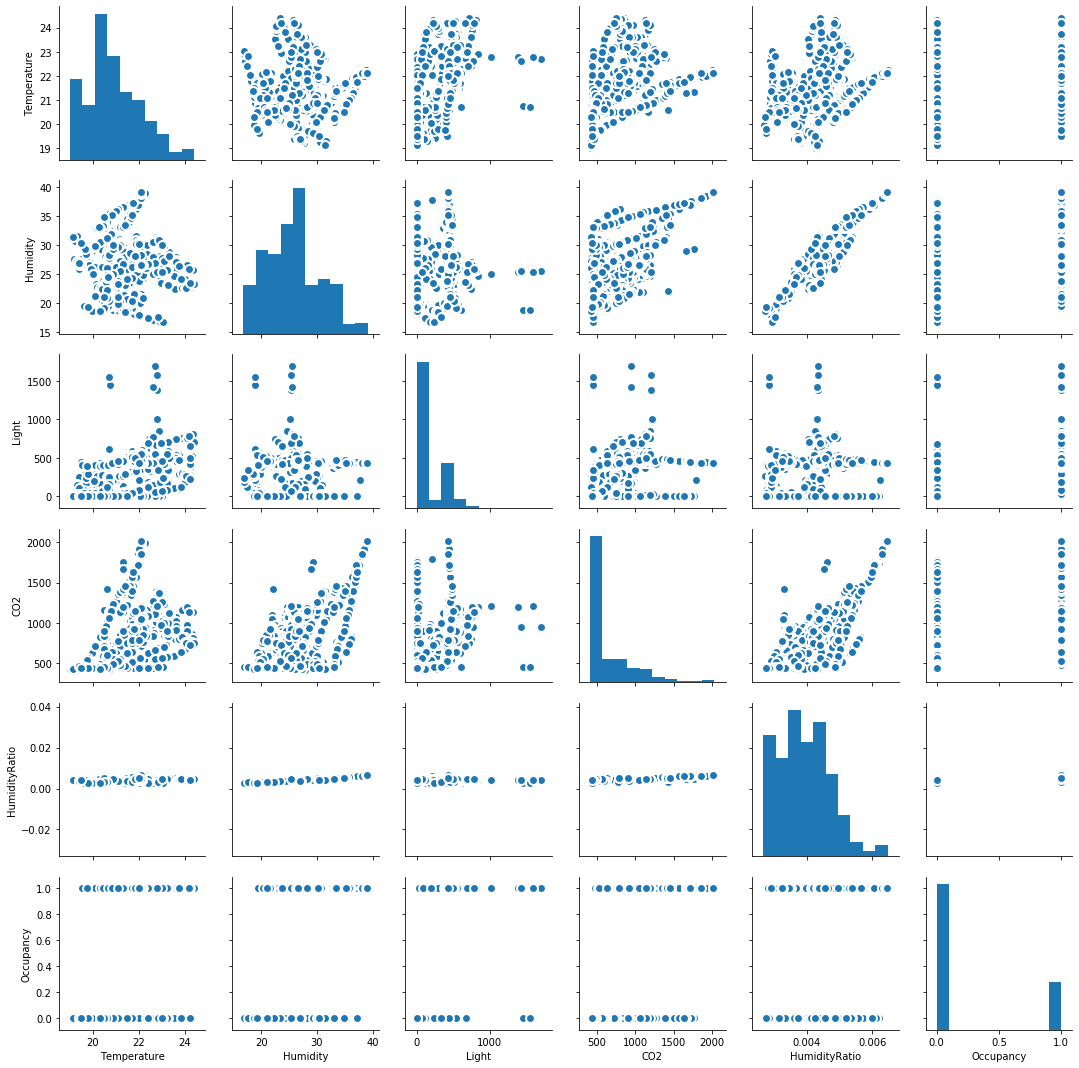

In [188]:
# Рассмотрим взаимосвязь признаков
plt.figure(figsize=(20,10), dpi= 20)
sns.pairplot(train, plot_kws = dict(s = 80, linewidth=2))
plt.show()

In [150]:
# Найдем дисперсию данных
train.groupby('Occupancy').var()

,Temperature,Humidity,Light,CO2,HumidityRatio
Occupancy,,,,,
0,1.022080,21.024831,8193.719088,23980.740141,4.521023e-07
1,0.699516,23.965442,7127.286554,104766.109083,6.969789e-07


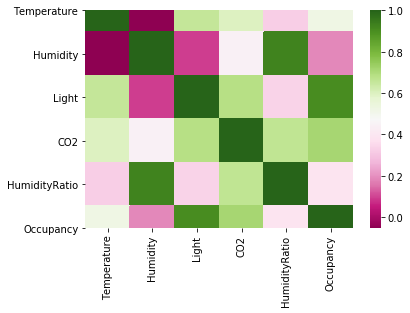

In [211]:
# Построим корреляционную матрицу
sns.heatmap(train.corr(), cmap='PiYG')

In [152]:
# Для лучшей читабельности представим в виде таблицы
train.corr()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
Temperature,1.000000,-0.049097,0.655458,0.597588,0.323295,0.524851
Humidity,-0.049097,1.000000,0.097879,0.444851,0.927516,0.188871
Light,0.655458,0.097879,1.000000,0.685222,0.338397,0.908617
CO2,0.597588,0.444851,0.685222,1.000000,0.662796,0.711089
HumidityRatio,0.323295,0.927516,0.338397,0.662796,1.000000,0.383737
Occupancy,0.524851,0.188871,0.908617,0.711089,0.383737,1.000000


На основе корреляционной матрицы можно сделать сделать вывод о сильной коррелируемости целевого признака с освещенностью и концентрацией CO2 и слабой коррелируемости с HumidityRatio и Humidity.
При этом HumidityRatio и Humidity коррелируют довольно сильно между собой, один из признаков можно считать избыточным, потому что он может только худшать качество модели, поэтому мы не будем брать Humidity во внимание.

#### Проверка сбалансированности входных данных

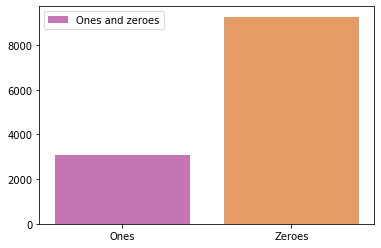

In [153]:
# Считаем количество нулей
train_zeroes = len(train[train['Occupancy'] == 0])
# Считаем количество единиц
train_ones = len(train[train['Occupancy'] == 1])

x = np.array(['Ones', 'Zeroes'])
y = np.array([train_ones, train_zeroes])

colors = np.random.rand(7, 4)    # RGB
plt.bar(x, y, label = 'Ones and zeroes', color = colors)
plt.legend()
# plt.savefig('Result.png')
plt.show()

Проверка показала дисбаланс выборки.

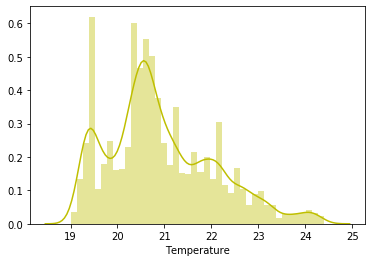

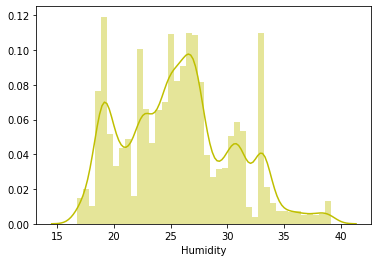

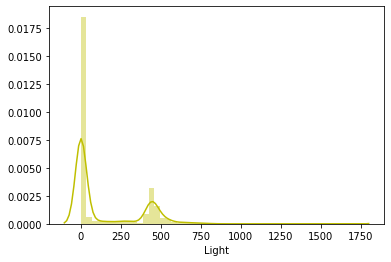

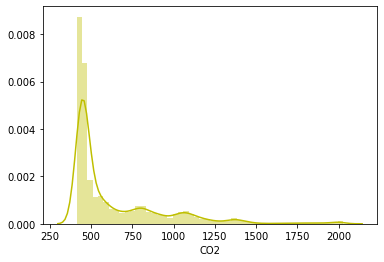

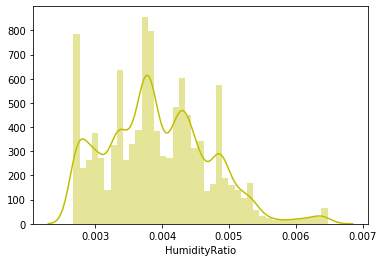

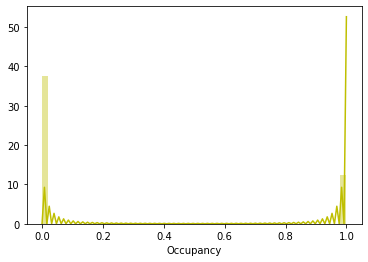

In [154]:
for i in train.var().index:
    sns.distplot(train[i], color = 'y')
    plt.show()

#### Разбиение данных на train и validation сеты

In [155]:
# Пусть четверть данных уйдет на проверку
from sklearn.model_selection import train_test_split
train, validation = train_test_split(train, test_size=0.25)

### Алгоритмы бинарной классификации

In [156]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

Построим функцию для тестирования классификаторов

In [157]:
# вспомогательные массивы для построения графика
name_helper = []
train_helper_acc = []
val_helper_acc = []
train_helper_f1 = []
val_helper_f1 = []

# используем предварительно отобранные признаки
cols_x = ['Temperature', 'Light', 'CO2', 'HumidityRatio']   
# целевой признак
col_y = 'Occupancy'

# функция тестирования классификатора
def test_classifier(classifier, classifier_name):
    
    # обучаем классификатор
    classifier.fit(train[cols_x], train[col_y])
    
    # определяем точность для тестовой выборки
    y_train = classifier.predict(train[cols_x])
    y_train_acc = accuracy_score(train[col_y], y_train)
    y_train_f1 = f1_score(train[col_y], y_train)
    
    # определяем точность для валидационной выборки
    y_val = classifier.predict(validation[cols_x])
    y_val_acc = accuracy_score(validation[col_y], y_val)
    y_val_f1 = f1_score(validation[col_y], y_val)

    # сохраняем в массивы
    name_helper.append(classifier_name)
    train_helper_acc.append(y_train_acc)
    val_helper_acc.append(y_val_acc)
    train_helper_f1.append(y_train_f1)
    val_helper_f1.append(y_val_f1)
    
    print('Accuracy для алгоритма {} на обучающей выборке = {}, на проверочной выборке = {};\
 F1 мера на обучающей выборке = {}, на проверочной выборке = {}'\
          .format(classifier_name, round(y_train_acc, 4), round(y_val_acc, 4), round(y_train_f1, 4), round(y_val_f1, 4)))
    
    return classifier

#### Дерево решений

In [158]:
from sklearn.tree import DecisionTreeClassifier
classifier = test_classifier(DecisionTreeClassifier(), 'DT')

Accuracy для алгоритма DT на обучающей выборке = 1.0, на проверочной выборке = 0.988; F1 мера на обучающей выборке = 1.0, на проверочной выборке = 0.9762


Для дерева решений исследуем влияние каждого признака

In [159]:
for column, i in zip(cols_x, classifier.feature_importances_):
    print(column, ": ", round(i, 4))

Temperature :  0.013
Light :  0.945
CO2 :  0.0272
HumidityRatio :  0.0148


По результатам проверки Light - наиболее значимый признак для прогнозирования результата

#### Метод k ближайших соседей

In [160]:
from sklearn.neighbors import KNeighborsClassifier
test_classifier(KNeighborsClassifier(), 'KNN')

Accuracy для алгоритма KNN на обучающей выборке = 0.9898, на проверочной выборке = 0.9854; F1 мера на обучающей выборке = 0.9798, на проверочной выборке = 0.9712


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

#### Логистическая регрессия

In [161]:
from sklearn.linear_model import LogisticRegression
test_classifier(LogisticRegression(), 'LR')

Accuracy для алгоритма LR на обучающей выборке = 0.9865, на проверочной выборке = 0.9835; F1 мера на обучающей выборке = 0.9734, на проверочной выборке = 0.9677


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

#### Градиентный бустинг

In [162]:
from sklearn.ensemble import GradientBoostingClassifier
test_classifier(GradientBoostingClassifier(), 'GB')

Accuracy для алгоритма GB на обучающей выборке = 0.9931, на проверочной выборке = 0.9844; F1 мера на обучающей выборке = 0.9862, на проверочной выборке = 0.9693


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

#### Случайный лес

In [163]:
from sklearn.ensemble import RandomForestClassifier
test_classifier(RandomForestClassifier(n_estimators=100,
                               max_depth=12,
                               random_state=4,
                               oob_score=True,
                               n_jobs=-1), 'RF')

Accuracy для алгоритма RF на обучающей выборке = 0.9995, на проверочной выборке = 0.9899; F1 мера на обучающей выборке = 0.9989, на проверочной выборке = 0.98


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=12, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=True, random_state=4, verbose=0,
                       warm_start=False)

#### Беггинг

In [164]:
from sklearn.ensemble import BaggingClassifier
test_classifier(BaggingClassifier(), 'BC')

Accuracy для алгоритма BC на обучающей выборке = 0.9987, на проверочной выборке = 0.9883; F1 мера на обучающей выборке = 0.9974, на проверочной выборке = 0.9767


BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False,
                  max_features=1.0, max_samples=1.0, n_estimators=10,
                  n_jobs=None, oob_score=False, random_state=None, verbose=0,
                  warm_start=False)

#### Адаптивный бустинг

In [165]:
from sklearn.ensemble import AdaBoostClassifier

In [166]:
test_classifier(AdaBoostClassifier(
                         algorithm="SAMME",
                         n_estimators=1), 'AB')

Accuracy для алгоритма AB на обучающей выборке = 0.9867, на проверочной выборке = 0.9841; F1 мера на обучающей выборке = 0.9738, на проверочной выборке = 0.969


AdaBoostClassifier(algorithm='SAMME', base_estimator=None, learning_rate=1.0,
                   n_estimators=1, random_state=None)

### Сравнение результатов моделей

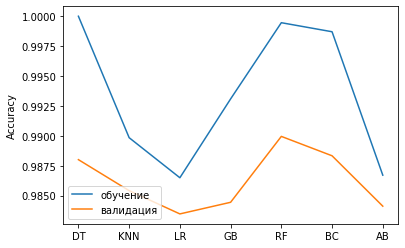

In [170]:
# По Accuracy
x = range(len(train_helper_acc))
plt.plot(x, train_helper_acc)
plt.plot(x, val_helper_acc)
plt.xticks(x, name_helper)
plt.ylabel('Accuracy')
plt.legend(['обучение', 'валидация'], loc='lower left')
plt.show()

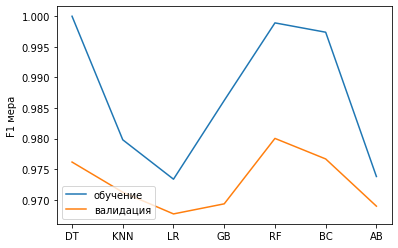

In [171]:
# По F1 мере
x = range(len(train_helper_f1))
plt.plot(x, train_helper_f1)
plt.plot(x, val_helper_f1)
plt.xticks(x, name_helper)
plt.ylabel('F1 мера')
plt.legend(['обучение', 'валидация'], loc='lower left')
plt.show()

По результатам диагностики можно сделать вывод о том, что классификатор Случайный лес показывает наиболее высокую точнось.
Это связано со сложностью алгоритмов.
Так же наблюдаются более хорошие показатели на тренировочной выборке, в отличие от проверочной, хотя разница не является критичной.

### Предсказания для новых данных  

Выбираем Дерево решений как лучший классификатор

In [174]:
col_y = 'Occupancy'
cols_x = ['Temperature', 'Light', 'CO2', 'HumidityRatio']   

clf = DecisionTreeClassifier()
clf.fit(train[cols_x], train[col_y])

occupancy_predicted = clf.predict(test[cols_x])
# Сохраним результат
test['result'] = occupancy_predicted
test.to_csv('result.csv')

In [178]:
# Выведем результат
df = pd.read_csv('result.csv', delimiter="," , index_col='id')
df.head(10)

,date,Temperature,Humidity,Light,CO2,HumidityRatio,result
id,,,,,,,
0,12.02.2015,22.315000,26.550,461.50,548.000000,0.004425,1
1,12.02.2015,22.290000,26.550,454.00,546.250000,0.004418,1
2,12.02.2015,22.323333,26.600,454.00,542.666667,0.004436,1
3,12.02.2015,22.290000,26.600,454.00,543.333333,0.004427,1
4,12.02.2015,22.315000,26.600,450.25,551.750000,0.004433,1
5,12.02.2015,22.290000,26.650,439.00,555.000000,0.004435,1
6,12.02.2015,22.290000,26.650,439.00,552.750000,0.004435,1
7,12.02.2015,22.290000,26.745,439.00,555.000000,0.004451,1
8,12.02.2015,22.290000,26.790,439.00,554.000000,0.004458,1


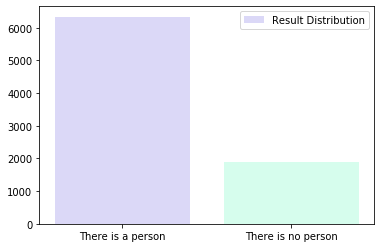

In [213]:
yes = len(df[df.result == 0])
no = len(df[df.result == 1])

x = np.array(['There is a person', 'There is no person'])
y = np.array([yes, no])

colors = np.random.rand(7, 4)    # RGB
plt.bar(x, y, label = 'Result Distribution', color = colors)
plt.legend()
# plt.savefig('Result.png')
plt.show()

### Вывод

Мы научились предсказывать нахождение человека в помещении. Наилучший классификатор, который нам удалось получить - Случайный лес